# Loading and Evaluating Multiple Models

This notebooks serves as a guide on how to load multiple models that were saved in the way described in [workbook.ipynb](workbook.ipynb). We will also look at how to evaluate them using an independent test dataset.

In [1]:
import json
import os
from pathlib import Path
from urllib.request import urlretrieve

import awkward as ak
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from models import from_config

# Load models

In [2]:
save_path = Path("saved_models")

In [3]:
!ls -la $save_path

total 104
drwxr-xr-x. 32 arvanitis.vyron campususer 32 Jul  4 17:01 .
drwxr-xr-x.  9 arvanitis.vyron campususer 34 Jul  6 12:18 ..
drwxr-xr-x.  2 arvanitis.vyron campususer  5 Jul  4 15:56 combined_variable
drwxr-xr-x.  2 arvanitis.vyron campususer  5 Jun 29 11:54 deepset
drwxr-xr-x.  2 arvanitis.vyron campususer  5 Jun 29 11:54 deepset_combined
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  6 11:50 deepset_combined_wgcn
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 15:08 deepset_combined_wgcn_no_E
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 15:08 deepset_combined_wgcn_no_p
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 15:08 deepset_combined_wgcn_no_prodTime
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 16:19 deepset_combined_wgcn_normalize
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 15:08 deepset_combined_wgcn_no_x
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul  4 15:08 deepset_combined_wgcn_no_x_y
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Jul

In [4]:
# manually select models to evaluate
configs = ["deepset", "deepset_combined", "deepset_gcn", "deepset_combined_wgcn","transformer"]#, "deepset_combined_wgcn_normalized"]

# alternative: all models in `save_path`
# configs = [path.name for path in save_path.iterdir()]
configs

['deepset',
 'deepset_combined',
 'deepset_gcn',
 'deepset_combined_wgcn',
 'transformer']

In [5]:
models = {}
for tag in configs:
    model_path = save_path / tag
    with open(model_path / "config.json") as f:
        config = json.load(f)
    model = from_config(config)
    state = torch.load(model_path / "state.pt")
    model.load_state_dict(state)
    models[tag] = model

/home/a/Arvanitis.Vyron/.conda/envs/ParticlePhysicsLab/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [6]:
models

{'deepset': DeepSet(
   (deep_set_layer): DeepSetLayer(
     (per_item_mlp): Sequential(
       (0): Linear(in_features=8, out_features=32, bias=True)
       (1): ReLU()
     )
     (global_mlp): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): ReLU()
     )
   )
   (output_layer): OutputLayer(
     (output_layer): Sequential(
       (0): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 'deepset_combined': CombinedModel(
   (embedding_layer): Embedding(185, 8)
   (deep_set_layer): DeepSetLayer(
     (per_item_mlp): Sequential(
       (0): Linear(in_features=16, out_features=32, bias=True)
       (1): ReLU()
     )
     (global_mlp): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): ReLU()
     )
   )
   (output_layer): OutputLayer(
     (output_layer): Sequential(
       (0): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 'deepset_gcn': DeepSet_wGCN(
   (gcn_layer): GCN(
   

# Load test data

In [7]:
from utils import GraphDataset, load_data, map_np, collate_fn, preprocess, get_adj, loss_fn, accuracy_fn

In [8]:
filename = "smartbkg_dataset_4k_testing.parquet"
url = "https://zenodo.org/records/15303496/files/smartbkg_dataset_4k_testing.parquet?download=1"
# url = ... # url for testdata will be provided on second lab day

In [9]:
if not os.path.exists(filename):
    urlretrieve(url, filename)

In [10]:
feature_columns = ["prodTime", "x", "y", "z", "energy", "px", "py", "pz"]
df, labels = load_data(filename, row_groups=[0])

In [11]:
with open("pdg_mapping.json") as f:
    pdg_mapping = dict(json.load(f))
df["pdg_mapped"] = map_np(df.pdg, pdg_mapping, fallback=len(pdg_mapping) + 1)

In [12]:
data = preprocess(df, pdg_mapping=pdg_mapping, feature_columns=feature_columns)

In [13]:
data["adj"] = [get_adj(index, mother) for index, mother in zip(data["index"], data["mother"])]

In [14]:
dl = torch.utils.data.DataLoader(
    GraphDataset(feat=data["features"], pdg=data["pdg_mapped"], adj=data["adj"], y=labels),
    batch_size=256,
    collate_fn=collate_fn
)

# Evaluation

If we let some test data run through one of our trained models, each event in that dataset will be mapped to a number between 0 and 1. This is due to the sigmoid activation function used for every last layer. The output value can be interpreted as the confidence the models has in a particular event passing the skimming. In order to decide which events get thrown away prior to the detector simulation, a threshold needs to be selected. That way every event which generated an output less than the threshold gets thrown away and the others are kept. To each threshold, there is a corresponding pair of true and false positive rates (FPR, TPR). We can plot them against each other, leading to a *reciever operating characteristic* (ROC) curve. Looking at the graphic below, this curve can be used to evaluate the model's performance, which can be quantified by calculating the area under the ROC curve (auc).  

![](figures/Roc_curve.png)

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, auc

The following function will run our model once through the DataLoader to produce pairs of model outputs (`logits`) and targets (`y`):

In [16]:
def evaluate(model, dl):
    model.eval()
    out_y = []
    out_logits = []
    for x, y, mask in tqdm(dl):
        out_y.append(y)
        with torch.no_grad():
            logits = model(x, mask=mask)
        out_logits.append(logits.squeeze())

    return torch.cat(out_y), torch.cat(out_logits)

In [17]:
for name, model in models.items():
    print(name)
    print(model)

deepset
DeepSet(
  (deep_set_layer): DeepSetLayer(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): OutputLayer(
    (output_layer): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
deepset_combined
CombinedModel(
  (embedding_layer): Embedding(185, 8)
  (deep_set_layer): DeepSetLayer(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): OutputLayer(
    (output_layer): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
deepset_gcn
DeepSet_wGCN(
  (gcn_layer): GCN(
    (linear): Linear(in_features=8, out_features=32

In [18]:
scores = {}
for name, model in models.items():
    print("Evaluating", name)
    scores[name] = evaluate(model, dl)

Evaluating deepset


100%|██████████| 391/391 [00:01<00:00, 258.68it/s]


Evaluating deepset_combined


100%|██████████| 391/391 [00:01<00:00, 298.03it/s]


Evaluating deepset_gcn


100%|██████████| 391/391 [00:01<00:00, 214.64it/s]


Evaluating deepset_combined_wgcn


100%|██████████| 391/391 [00:02<00:00, 173.69it/s]


Evaluating transformer


100%|██████████| 391/391 [00:04<00:00, 82.14it/s]


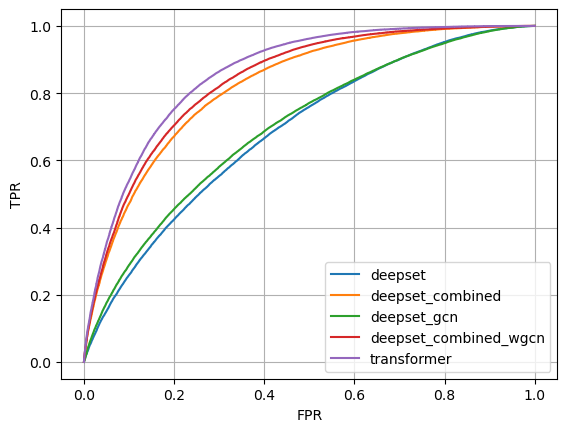

In [19]:
for name, (y_true, y_logits) in scores.items():
    y_score = y_logits.sigmoid()
    fpr, tpr, thr = roc_curve(y_true.numpy(), y_score.numpy())
    plt.plot(fpr, tpr, label=name)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()

In [20]:
summary = []
for (name, model), (y_true, y_logits) in zip(models.items(), scores.values()):
    y_score = y_logits.sigmoid()
    fpr, tpr, thr = roc_curve(y_true.numpy(), y_score.numpy())
    loss = loss_fn(y_logits, y_true)
    accuracy = accuracy_fn(y_logits, y_true)
    summary.append(
        {
            "Model": name,
            "Loss": loss.item(),
            "Accuracy": accuracy.item(),
            "AUC": auc(fpr, tpr),
        }
    )

In [21]:
summary

[{'Model': 'deepset',
  'Loss': 0.6369075775146484,
  'Accuracy': 0.6312100291252136,
  'AUC': 0.6868934867650649},
 {'Model': 'deepset_combined',
  'Loss': 0.5147445797920227,
  'Accuracy': 0.7465500235557556,
  'AUC': 0.8223980083701253},
 {'Model': 'deepset_gcn',
  'Loss': 0.6297855973243713,
  'Accuracy': 0.6433600187301636,
  'AUC': 0.6992635028775778},
 {'Model': 'deepset_combined_wgcn',
  'Loss': 0.4971986711025238,
  'Accuracy': 0.7601199746131897,
  'AUC': 0.838226702481858},
 {'Model': 'transformer',
  'Loss': 0.4598841369152069,
  'Accuracy': 0.784030020236969,
  'AUC': 0.8601585327451317}]

In [22]:
pd.DataFrame(summary).set_index("Model")

,Loss,Accuracy,AUC
Model,,,
deepset,0.636908,0.63121,0.686893
deepset_combined,0.514745,0.74655,0.822398
deepset_gcn,0.629786,0.64336,0.699264
deepset_combined_wgcn,0.497199,0.76012,0.838227
transformer,0.459884,0.78403,0.860159


# Speedup estimation

How do we finally choose a threshold? We want our model to deliver the highest possible speedup to our simulation chain. With certain assumptions (see [labday.md](labday.md)), a formula can be derived that only depends on FPR, TPR. This will be your job. With that you can plot against the thresholds a speedup curve and find its maximum as well as the corresponding optimal threshold.

In [23]:
def speedup(fpr, tpr):
    r = 0.05
    speed_up = (101 * tpr) / (1 + (tpr*r+fpr*(1-r))*100) 
    return speed_up

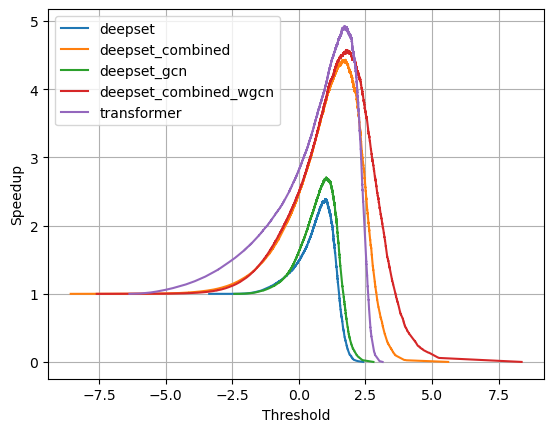

In [24]:
for i, (model_name, (labels, score)) in enumerate(scores.items()):
    fpr, tpr, thr = roc_curve(labels, score)
    s = speedup(fpr, tpr)
    s_max = max(s)
    thr_max = thr[np.argmax(s)]
    summary[i]["Max. Speedup"] = s_max
    summary[i]["Best Threshold"] = thr_max
    plt.plot(thr[1:], s[1:], label=model_name)
plt.xlabel("Threshold")
plt.ylabel("Speedup")
plt.legend()
plt.grid()

In [25]:
pd.DataFrame(summary).set_index("Model")

,Loss,Accuracy,AUC,Max. Speedup,Best Threshold
Model,,,,,
deepset,0.636908,0.63121,0.686893,2.389766,1.014572
deepset_combined,0.514745,0.74655,0.822398,4.431707,1.746598
deepset_gcn,0.629786,0.64336,0.699264,2.704084,1.023239
deepset_combined_wgcn,0.497199,0.76012,0.838227,4.575799,1.774384
transformer,0.459884,0.78403,0.860159,4.927863,1.714683
